**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.**

In [1]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install git+https://github.com/michalgregor/class_utils.git

  Cloning https://github.com/michalgregor/class_utils.git to /tmp/pip-req-build-eg2ttpqc
  Running command git clone -q https://github.com/michalgregor/class_utils.git /tmp/pip-req-build-eg2ttpqc
     |████████████████████████████████| 276kB 3.4MB/s 
     |████████████████████████████████| 112kB 49.2MB/s 
     |████████████████████████████████| 57.7MB 67kB/s 
     |████████████████████████████████| 2.0MB 32.3MB/s 
  Created wheel for class-utils: filename=class_utils-0.1-cp36-none-any.whl size=6463 sha256=e322fc7f115683e9573877ddcf9ff95a7c4a214c3e643e65721dcaddbad465e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-vhi_9yb3/wheels/0c/d3/63/b380d96ed74ced47fcdb67bfb9aee184bfdc970b956a65096d
  Created wheel for lime: filename=lime-0.2.0.0-cp36-none-any.whl size=284181 sha256=15923641297f19c3eaec57afd9f05f3ff32c62bb5231ddb624270cb1ab86a041
  Stored in directory: /root/.cache/pip/wheels/22/f2/ec/e5ebd07348b2b1ac722e91c2f549fcc220f7d5f25497a61232
  Created wheel for pdpbox: filename=PDPb

In [2]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, KBinsDiscretizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from class_utils import error_histogram
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p output
!mkdir -p data
!wget -nc -O data/sigmoid_regression_data.csv https://www.dropbox.com/s/p5q7gzupa2ndw55/sigmoid_regression_data.csv?dl=1

--2020-04-20 13:04:39--  https://www.dropbox.com/s/p5q7gzupa2ndw55/sigmoid_regression_data.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/p5q7gzupa2ndw55/sigmoid_regression_data.csv [following]
--2020-04-20 13:04:39--  https://www.dropbox.com/s/dl/p5q7gzupa2ndw55/sigmoid_regression_data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3a4c08bde4cfb38c96f61a484.dl.dropboxusercontent.com/cd/0/get/A2MmEbS959IQUPIed3XS0L1ubfxxhAW3Gtgqd10guuiULOEjtkWbwiOuTbQW3YDHlxkhnaudQkdMzt2-eYtJiY9nojwrAiQT4_UxwdRTq3QD3qKILujOEtJugb9Mv9Gb79E/file?dl=1# [following]
--2020-04-20 13:04:39--  https://ucd3a4c08bde4cfb38c96f61a484.dl.dropboxusercontent.com/cd/0/get/A2MmEbS959IQUPIed3XS0L1ubfxxhAW3Gtgqd10guuiULOEjtkWbwiOuTbQW3YDHlxk

# Regression and Corresponding Data Preprocessing

As our next example we will show how to solve a simple regression task. As our regression method (just as in the case of classification) we will use the $k$ nearest neighbours method (KNN). For classification the prediction was determined by voting among the $k$ nearest neighbours. In the case of regression the prediction is formed by computing the average of the $k$ nearest neighbours' values. 

## Loading the Dataset

Our example will begin as usual: by loading a dataset from a CSV file: in this case the file will only have two columns. The first column, $x$, will represent the input of our model and the second, $y$, will represent the desired output.

In [4]:
df = pd.read_csv("data/sigmoid_regression_data.csv")
df.head()

,x,y
0,-20.000000,0.004982
1,-14.911349,0.003562
2,-14.527971,0.000296
3,-7.840879,-0.001815
4,-4.745229,0.000037


## Stratification When Splitting the Dataset

The next step, of course, is to split the dataset into the train and the test set. Let us recall that we used stratification by the label when splitting the dataset for a classification task. This was to ensure that the ratio of the classes in the training and the testing set will remain close to that in the original dataset.

Obviously in the case of regression we cannot do the same thing – or at least not quite as easily as for classification. This is because the desired outputs are now continuous. In some cases, however, it may still be desirable to apply some kind of stratification – especially if the dataset is small, as it is in our case. There is otherwise a risk that the training and the testing set will not be representative.

To show how such problem might manifest itself is very easy: all we need to do is to split our dataset in the normal way without using stratification and to visualize the training and the testing set in the same plot:

In [0]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=4)

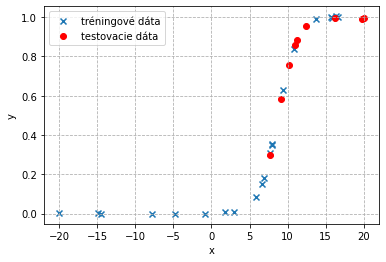

In [6]:
plt.scatter(df_train['x'], df_train['y'], marker='x', label="tréningové dáta")
plt.scatter(df_test['x'], df_test['y'], c='r', label="testovacie dáta")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(ls='--')
plt.legend()
plt.savefig("output/regression_split_plain.pdf", bbox_inches='tight', ppad_inches=0)

What we should be able to see in the plot is that the testing data does not even begin to cover the entire space. So how do we apply stratification to prevent this problem? Given that the column by which we stratify should be discrete, the simplest solution is, of course, to discretize our continuous column – e.g. using the ``KBinsDiscretizer`` transformer from ``scikit-learn``. The discretization itself might look as follows:

In [0]:
kbins = KBinsDiscretizer(6, encode='ordinal')
y_stratify = kbins.fit_transform(df[['y']])

The discretized column ``y_stratify`` can now be used for stratification:

In [0]:
df_train, df_test = train_test_split(df, stratify=y_stratify,
                                 test_size=0.3, random_state=4)

When we visualize the results of such splitting, we should be able to observe that the samples have been split into the training and the testing set much more uniformly:

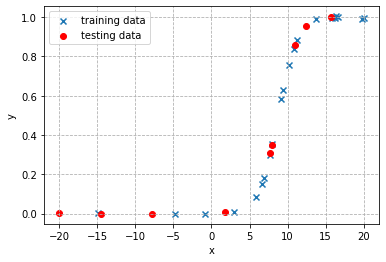

In [9]:
plt.scatter(df_train['x'], df_train['y'], marker='x', label="training data")
plt.scatter(df_test['x'], df_test['y'], c='r', label="testing data")
plt.xlabel('x')
plt.ylabel('y')
plt.grid(ls='--')
plt.legend()
plt.savefig("output/regression_split_stratif.pdf", bbox_inches='tight', ppad_inches=0)

---

## Task 1: Constructing the Pipeline

**The next step is, as usual, to construct the preprocessing pipeline. As the first step, determine which input columns are categorical and which are numeric and then create the same pipeline object that we have been using the previous examples.**

NOTE: It will not be necessary to preprocess the output column in our case.

---

In [0]:
categorical_inputs = [ ]  # ----

numeric_inputs = ['x']  # ----

output = 'y'

In [0]:
input_preproc = make_column_transformer(
    (make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OrdinalEncoder()),
     categorical_inputs),
    
    (make_pipeline(
        SimpleImputer(),
        StandardScaler()),
     numeric_inputs)
)
    

## Data Preprocessing

The data will be preprocessed in the usual way:

In [0]:
X_train = input_preproc.fit_transform(df_train[categorical_inputs+numeric_inputs])
Y_train = df_train[output].values

X_test = input_preproc.transform(df_test[categorical_inputs+numeric_inputs])
Y_test = df_test[output].values

## Training the Model

Our model will be trained using the unified interface – we will only need to change its type. We will be using a ``KNeighborsRegressor`` instead of a ``KNeighborsClassifier``.

In [13]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

## Testing the Model

Finally the behaviour of our model will be evaluated on the testing data. For regression we will naturally not use accuracy as a performance metric – regression has its own indicators. Among the most frequently used ones are the **mean squared error** (MSE):
\begin{equation}
MSE = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2.
\end{equation}
where $y_i$ is the desired output and $\hat{y}_i$ is the actual output of our model for sample $i$ from the dataset and $N$ is the total number of samples in the dataset.

and the **mean absolute error** (MAE):
\begin{equation}
MAE = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|.
\end{equation}

Mean squared error is more sensitive to large errors (due to the square). The advantage of mean absolute error is that it from the same scale as the data and it is therefore easier to interpret (even though it is alway possible to take the square root of the mean squared error as well). There is, of course, a number of other indicators (e.g. percentage errors, the coefficient of determination, etc.), but we will not be considering these in the present notebook.

Let us then use our regression model and compute predictions for the testing set.

In [0]:
y_test = model.predict(X_test)

We will compute and display the mean square and absolute error. Let us recall that the range of the outputs is approximately 0 to 1.

In [15]:
mse = mean_squared_error(Y_test, y_test)
mae = mean_absolute_error(Y_test, y_test)

print("MSE: {}".format(mse))
print("MAE: {}".format(mae))

MSE: 0.004582050028058121
MAE: 0.0476584966199359


To get a fuller idea of how the errors are distributed we can also visualize the entire distribution using the output and error histogram. We will standardize the outputs for the purposes of this plot to get the histograms of the outputs and the error to align. We will also use scaled data to compute the mean absolute error to ensure that it is on the same scale.

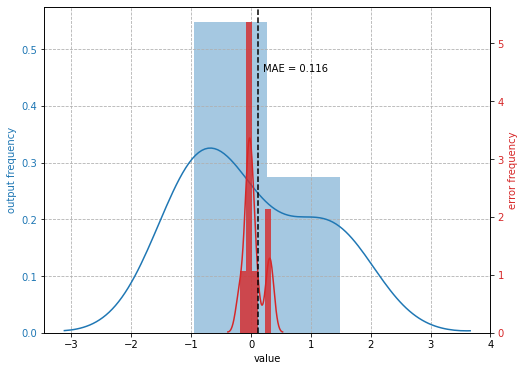

In [16]:
plt.figure(figsize=(8, 6))
error_histogram(Y_test, y_test, Y_fit_scaling=Y_train)
plt.savefig("output/error_output_histogram.pdf", bbox_inches='tight', ppad_inches=0)

## Visualizing the Regression Relationship

Given that our regression relationship is 2-dimensional, we can easily visualize it in a 2D plot and evaluate it visually as well.

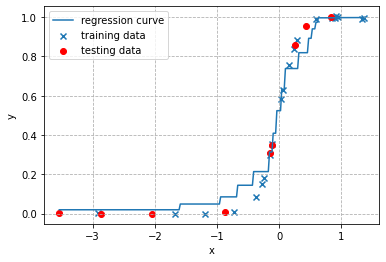

In [17]:
x_min = min(np.min(X_train), np.min(X_test))
x_max = max(np.max(X_train), np.max(X_test))

xx = np.linspace(x_min, x_max, 250).reshape((-1, 1))
yy = model.predict(xx)

plt.scatter(X_train, Y_train, marker='x', label="training data")
plt.scatter(X_test, Y_test, c='r', label="testing data")

plt.plot(xx, yy, label="regression curve")

plt.xlabel('x')
plt.ylabel('y')
plt.grid(ls='--')
plt.legend()

plt.savefig("output/knn_regression.pdf", bbox_inches="tight", pad_inches=0)

One thing that we should notice in the plot is that the regression relationship is not smooth. This is, of course, because there are areas, where all the points share the same nearest neighbours and the output is therefore insensitive to the input unless it leaves the area. In later notebooks we will explore other kinds of models, which will be able to achieve better results.